In [1]:
!pip install sentence_transformers
!pip install transformers
!pip install wordcloud
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install sentence_transformers

In [3]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
warnings.filterwarnings('ignore')

In [4]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
warnings.filterwarnings('ignore')

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
full_df = pd.read_csv("/content/drive/MyDrive/DS301/metadata.csv")
dfs = []
for year in range(2020, 2021):
    df = pd.read_csv(f"/content/drive/MyDrive/DS301/deduplicated_dataset_{year}.csv", index_col=0)
    df.drop(columns=["minhash"], inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
# Left join on the "cord_uid" column
df = pd.merge(df, full_df[['cord_uid', 'abstract']], on="cord_uid", how="left")
df.dropna(subset=['abstract'], inplace=True) #drop articles with null abstracts
df.to_pickle("prepared_data.pkl")

In [7]:
DEVICE = "cuda"
SENTENCE_ENCODER = SentenceTransformer('all-mpnet-base-v2', device=DEVICE)
embeddings = SENTENCE_ENCODER.encode(df.abstract.tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2901 [00:00<?, ?it/s]

In [8]:
df['Embeddings'] = list(embeddings)

## Topics for 2020

In [9]:
year = 2020

df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

Processing year 2020 with 92806 samples...


In [10]:
# Concat embeddings to dataframe
embedding_df = np.stack(df_year.Embeddings.tolist())
print(embedding_df.shape)

(92806, 768)


In [11]:
# Perform PCA
pca = PCA(n_components=0.90)
embedding_pca = pca.fit_transform(embedding_df)
print(f"Reduced {embedding_df.shape[1]} to {embedding_pca.shape[1]} dimensions.")

Reduced 768 to 220 dimensions.


## DBSCAN

In [12]:
# compute the k nearest neighbors and plot the results
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embedding_pca)
distances, indices = nbrs.kneighbors(embedding_pca)

In [13]:
# sort the distances
sorted_distances = np.sort(distances[:, -1])

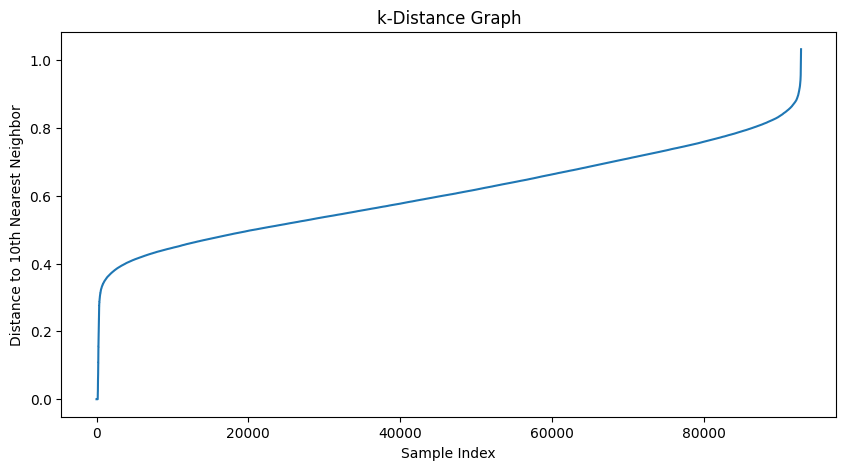

In [14]:
# plot the k-distance graph
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.xlabel("Sample Index")
plt.ylabel("Distance to 10th Nearest Neighbor")
plt.title("k-Distance Graph")
plt.show()

In [15]:
# perform hdbscan using sklearn
dbscan = DBSCAN(eps=0.4, min_samples=6)
dbscan.fit(embedding_pca)

DBSCAN(eps=0.4, min_samples=6)

In [16]:
#value counts of each cluster
pd.Series(dbscan.labels_).value_counts()

-1      88771
 0        934
 4        427
 11       228
 2        211
        ...  
 146        5
 142        5
 143        4
 145        4
 132        3
Name: count, Length: 151, dtype: int64

## Mini-Batch KMeans

In [17]:
# use minibatchkmeans to find the optimal number of clusters
# initialize the cluster range and inertia dictionary
kmeans_data = {}
for k in tqdm(range(10, 500, 5)):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=1000, max_iter=100)
    kmeans.fit(embedding_pca)
    kmeans_data[k] = dict(
        labels=kmeans.labels_,
        inertia=kmeans.inertia_,
    )

100%|██████████| 98/98 [06:56<00:00,  4.25s/it]


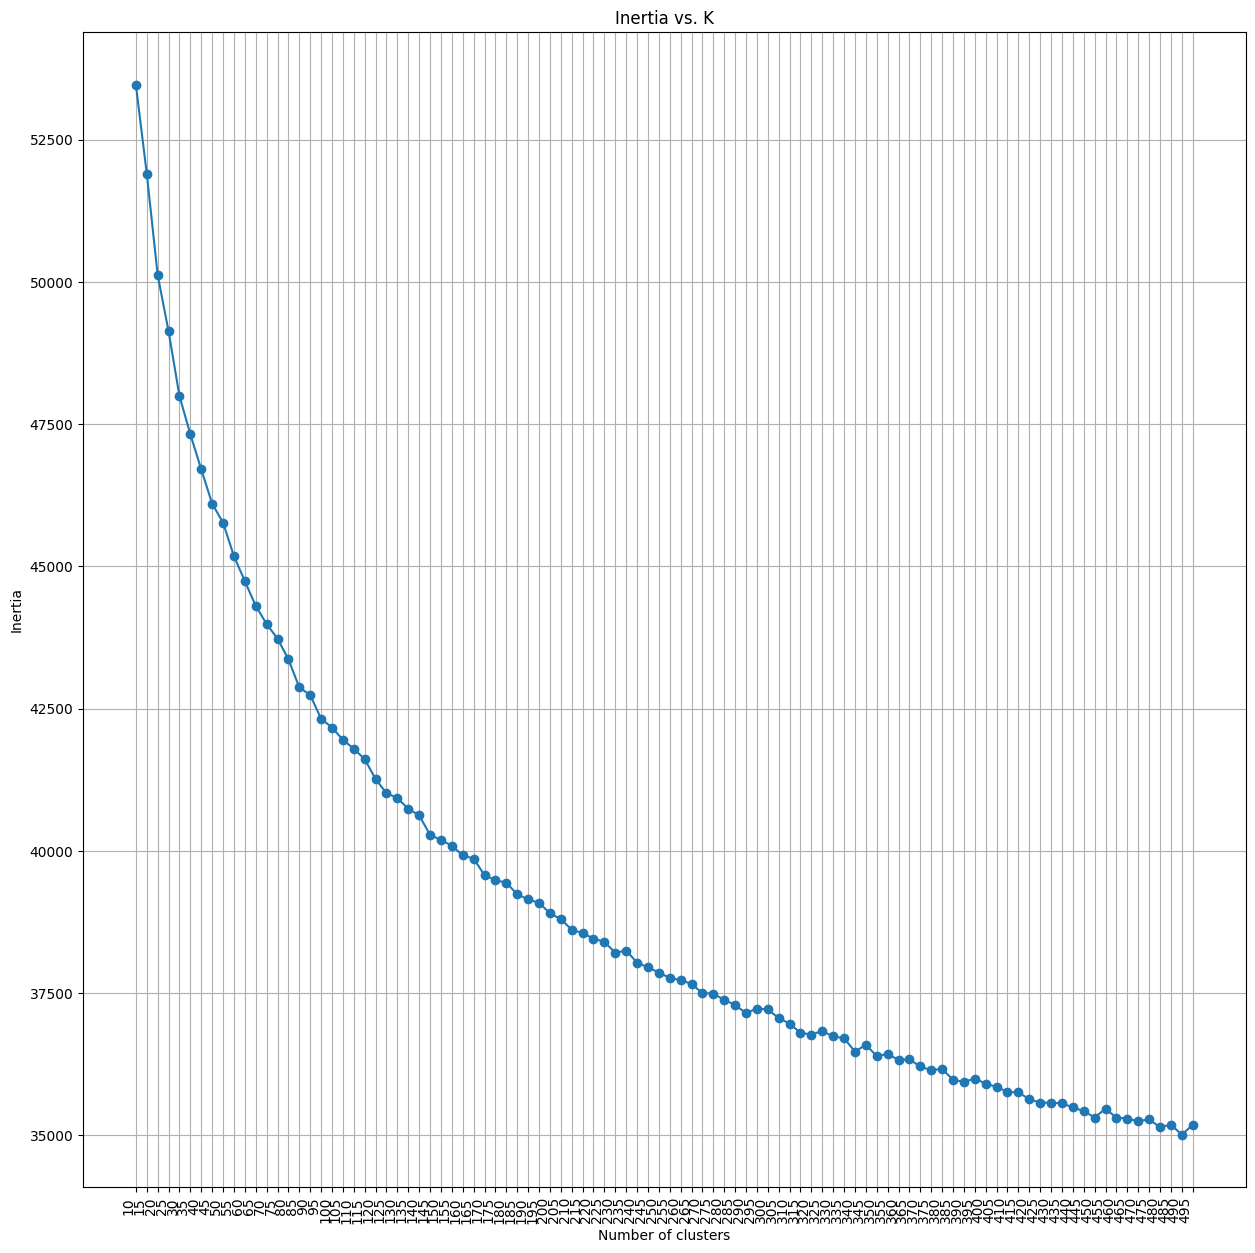

In [18]:
# plot the inertia vs. K
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(list(kmeans_data.keys()), [km['inertia'] for km in kmeans_data.values()], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. K')
ax.set_xticks(list(kmeans_data.keys()))
ax.grid(True)
plt.xticks(rotation=90, ha='right')
plt.show()

In [19]:
# choose K = 215
k = 215

In [43]:
# save the labels
topic_idx = kmeans_data[k]['labels']
df_year['topics215_idx'] = topic_idx
df_year.to_pickle('/content/drive/MyDrive/DS301/topics_215.pkl')
df_year.to_csv('/content/drive/MyDrive/DS301/topics_215.csv')

In [22]:
# tsne
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_pca)

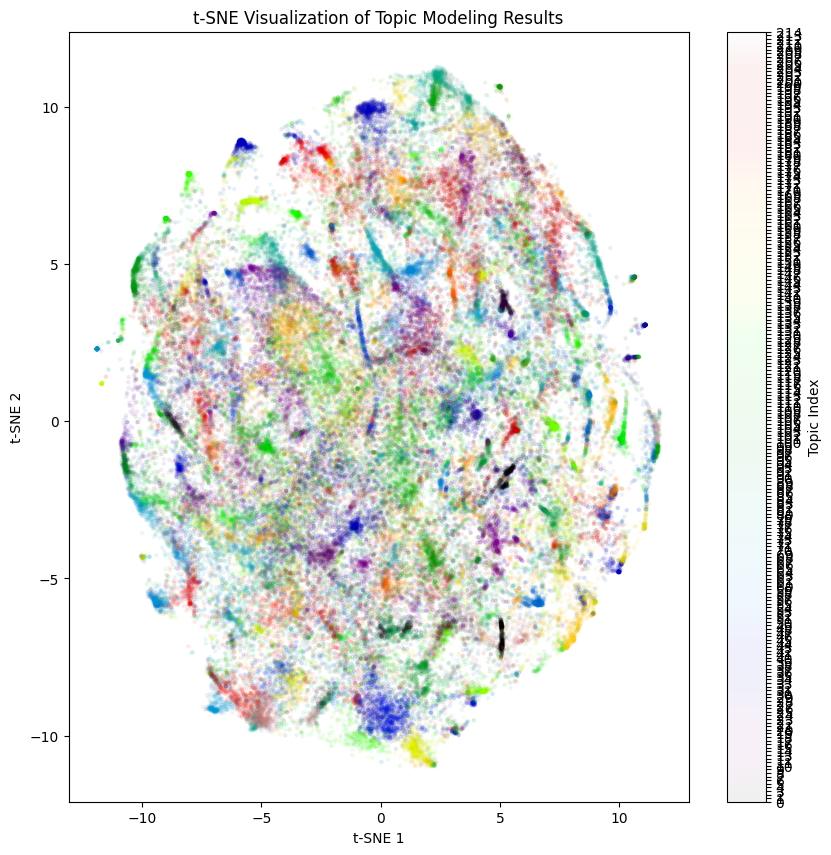

In [23]:
# Plot the T-SNE results
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], c=df_year.topics215_idx,
                     cmap=plt.cm.nipy_spectral, alpha=0.06, s=5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Topic Modeling Results")
# Add a colorbar for reference
cbar = plt.colorbar(scatter, ticks=range(215))
cbar.set_label('Topic Index')
plt.show()


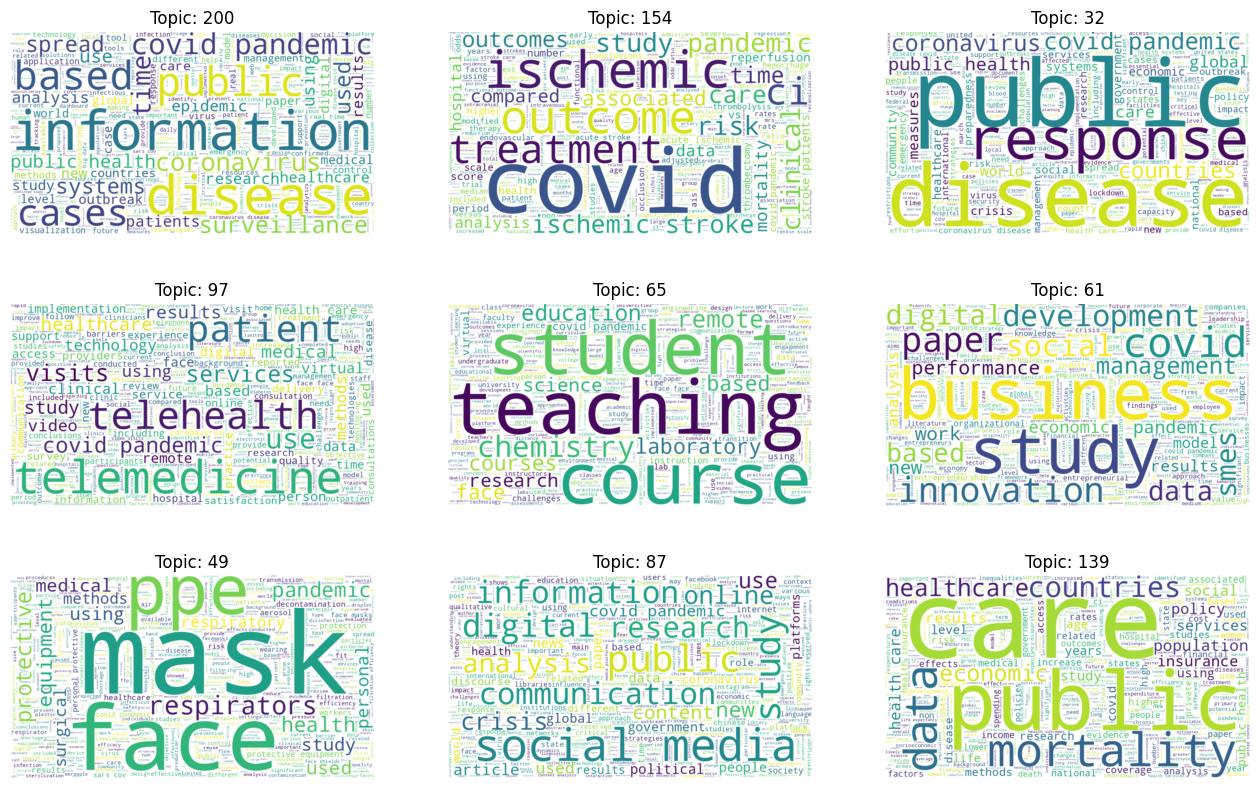

In [25]:
# Generate word cloud for 9 random selected topics
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()
pattern = re.compile("[^a-zA-Z]")

keywords = []

for ax_index, i in enumerate(np.random.choice(list(range(215)), 9, replace=False)):
    df_topic = df_year[df_year.topics215_idx == i]

    corpus = df_topic.abstract.values
    # Remove non-alphabetical characters
    corpus = [re.sub(pattern, " ", text) for text in corpus]

    # Use CountVectorizer to extract frequencies since it is more flexible
    # Remove words that appear in more than 50% of the documents
    # Also include bigrams
    vectorizer = CountVectorizer(max_df=0.5, stop_words="english",
                                 lowercase=True, ngram_range=(1, 2), max_features=1000)
    vectorizer.fit(corpus)

    # Get the word frequencies dict(string:float)
    # tokens = vectorizer.get_feature_names()
    tokens = vectorizer.get_feature_names_out()
    freqs = vectorizer.transform(corpus).sum(axis=0).A1
    freqs = freqs / freqs.max()
    tokens_to_freqs = dict(zip(tokens, freqs))
    # Sort the dict by values
    tokens_to_freqs = dict(sorted(tokens_to_freqs.items(), key=lambda x: x[1], reverse=True))
    # Get the top 10 keywords
    keywords.append(list(tokens_to_freqs.keys())[:10])

    # Word cloud
    wordcloud = WordCloud(width=900, height=500,
                          background_color="white", max_words=1628,
                          relative_scaling=1, normalize_plurals=False).generate_from_frequencies(tokens_to_freqs)
    # wordcloud.to_file("output/2020/topic_" + str(i) + ".png")
    ax = axes[ax_index]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Topic: " + str(i))

plt.show()

In [27]:
# # Save the keywords to file
# with open("output/2020/keywords.json", 'w') as f:
#     json.dump(keywords, f)

## Text Summarization

restart the kernal is strongly recommended before run the following code

In [30]:
# Load the dataframe
BART_SUMMARIZER = pipeline("summarization", model="facebook/bart-large-cnn", device='cuda')

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [44]:
# Load the dataframe
df_2020 = pd.read_pickle('/content/drive/MyDrive/DS301/topics_215.pkl')
df_2020.columns

Index(['cord_uid', 'title', 'publish_time', 'language', 'abstract',
       'Embeddings', 'topics215_idx'],
      dtype='object')

In [45]:
# Get the representative articles for each topic

topic_repr_articles = {}

for topic_idx in tqdm(df_2020.topics215_idx.unique()):
    # Get the embeddings for the topic
    df_topic = df_2020[df_2020.topics215_idx == topic_idx]
    topic_embeddings = np.stack(df_topic.Embeddings.values)

    # Perform PCA
    pca = PCA(n_components=0.9)
    emb_pca = pca.fit_transform(topic_embeddings)

    # Perform KMeans
    n_repr_articles = 5
    km = KMeans(n_clusters=n_repr_articles, random_state=0)
    km.fit(emb_pca)
    labels = km.labels_
    centroids = km.cluster_centers_

    # Get the representative articles based on the centroids
    repr_articles = []
    for label, centroid in zip(range(n_repr_articles), centroids):
        distances = np.linalg.norm(emb_pca - centroid, axis=1)
        repr_articles.append(df_topic.iloc[np.argmin(distances)].abstract)
    # Save the representative articles
    topic_repr_articles[topic_idx] = repr_articles

100%|██████████| 215/215 [00:59<00:00,  3.60it/s]


In [53]:
import os
import json

# Set the directory to your Google Drive path
directory = "/content/drive/MyDrive/DS301"

# Ensure the directory exists
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = f"{directory}/topic_repr_articles.json"

# Save topic_repr_articles to the specified file
with open(file_path, 'w') as f:
    json.dump(topic_repr_articles, f)


In [54]:
topic_idx = 165
#print (topic_repr_articles[topic_idx]) in a more readable way with rank
for i in range(5):
    print (topic_repr_articles[topic_idx][i])
    print ("")

Background: School closures around the world contributed to reducing the transmission of COVID-19. In the face of significant uncertainty around the epidemic impact of in-person schooling, policymakers, parents, and teachers are weighing the risks and benefits of returning to in-person education. In this context, we examined the impact of different school reopening scenarios on transmission within and outside of schools and on the share of school days that would need to be spent learning at a distance. Methods: We used an agent-based mathematical model of COVID-19 transmission and interventions to quantify the impact of school reopening on disease transmission and the extent to which school-based interventions could mitigate epidemic spread within and outside schools. We compared seven school reopening strategies that vary the degree of countermeasures within schools to mitigate COVID-19 transmission, including the use of face masks, physical distancing, classroom cohorting, screening,

In [56]:
import json
import os

# Set the path to where your file is located on Google Drive
file_path = "/content/drive/MyDrive/DS301/topic_repr_articles.json"

# Check if the file exists
if os.path.isfile(file_path):
    # Load topic_repr_articles and convert keys to int
    with open(file_path, 'r') as f:
        topic_repr_articles = json.load(f)
    topic_repr_articles = {int(k): v for k, v in topic_repr_articles.items()}
else:
    print(f"File not found: {file_path}")
    # Handle the missing file scenario


In [57]:
import os
import json

file_path = "/content/drive/MyDrive/DS301/summaries.json"

# Check if the file exists
if not os.path.isfile(file_path):
    print(f"File not found: {file_path}")
    # Handle the case where the file doesn't exist, perhaps by creating an empty dict
    topic_summaries = {}
else:
    # If the file exists, proceed to load it
    with open(file_path, 'r') as f:
        topic_summaries = json.load(f)
    topic_summaries = {int(k): v for k, v in topic_summaries.items()}


File not found: /content/drive/MyDrive/DS301/summaries.json


In [58]:
# Summarize the articles
for topic_idx in tqdm(df_2020.topics215_idx.unique()):
    topic_idx = int(topic_idx)

    # If topic already done, skip
    if topic_idx in topic_summaries:
        continue

    # Get the representative articles
    repr_articles = topic_repr_articles[topic_idx]
    # Summarize the articles
    summaries = []
    for article in repr_articles:

        # If number of tokens > 1023, discard the texts after that
        # Since the maximum allowed length to BART summarizer is 1024
        tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
        ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        while len(ids) > 1023:
            # If too long, cut half of an article
            article = article[:(len(article) // 2)]
            tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
            ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        # If length is already too short, we use itself as summary
        if len(tokens) < 50:
            sumamry = article
        else:
            summary = BART_SUMMARIZER(article, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

        summaries.append(summary)
    # Save the summaries
    topic_summaries[topic_idx] = summaries

    file_path = "/content/drive/MyDrive/DS301/summaries.json"

    # Save topic_summaries to the specified file
    with open(file_path, 'w') as f:
        json.dump(topic_summaries, f)


100%|██████████| 215/215 [13:23<00:00,  3.74s/it]


In [59]:
# Print the summaries
topic_idx = 0
for i in range(5):
    print (topic_summaries[topic_idx][i])
    print ("")

Covid - 19 has created a havoc all over the world pausing everyone's normal life and has become a major public health concern. Dental practitioners are at a higher risk because of its potential transmission via saliva, water droplets

The aim of this study was to assess the Knowledge, Attitudes and Practices (KAP) regarding the COVID-19 pandemic among dental undergraduate students. A total of 209 undergraduate dental students participated in the online survey. A majority

Oral hygiene is the practice of keeping one's oral cavity neat, clean in order to avoid any disease initiation, progression. A small population of Chennai of 174 was aware of oral hygiene, especially during the current COVID-19 situations

COVID-19 is a novel viral respiratory disease caused by a member of the coronavirus family, SARS-CoV-2. Dental practitioners are routinely exposed to infectious bodily excretions, for example, saliva,

The current outbreak of novel Covid-19, which is now declared as a ’pandemic’ by 

In [ ]:
df_year = pd.read_pickle('/content/drive/MyDrive/DS301/topics_215.pkl')
pattern = re.compile("[^a-zA-Z]")
keywords = []
for i in tqdm(range(215)):
    df_topic = df_year[df_year.topics215_idx == i]
    corpus = df_topic.abstract.values
    # Remove non-alphabetical characters
    corpus = [re.sub(pattern, " ", text) for text in corpus]
    # Use CountVectorizer to extract frequencies since it is more flexible
    # Remove words that appear in more than 50% of the documents
    # Also include bigrams
    vectorizer = CountVectorizer(max_df=0.5, stop_words="english",
                                 lowercase=True, ngram_range=(1, 2), max_features=1000)
    vectorizer.fit(corpus)
    # Get the word frequencies dict(string:float)
    # tokens = vectorizer.get_feature_names()
    tokens = vectorizer.get_feature_names_out()
    freqs = vectorizer.transform(corpus).sum(axis=0).A1
    freqs = freqs / freqs.max()
    tokens_to_freqs = dict(zip(tokens, freqs))
    # Sort the dict by values
    tokens_to_freqs = dict(sorted(tokens_to_freqs.items(), key=lambda x: x[1], reverse=True))
    # Get the top 10 keywords
    keywords.append(list(tokens_to_freqs.keys())[:10])
    # Word cloud
    wordcloud = WordCloud(width=900, height=500,
                          background_color="white", max_words=1628,
                          relative_scaling=1, normalize_plurals=False).generate_from_frequencies(tokens_to_freqs)
    wordcloud.to_file("/content/drive/MyDrive/DS301/topic_" + str(i) + ".png")
